Original notebook from: https://github.com/pangeo-data/pangeo/blob/master/gce/notebook/examples/sea-surface-height.ipynb

# Sea Surface Altimetry Data Analysis

For this example we will use gridded sea-surface altimetry data from The Copernicus Marine Environment:

http://marine.copernicus.eu/services-portfolio/access-to-products/?option=com_csw&view=details&product_id=SEALEVEL_GLO_PHY_L4_REP_OBSERVATIONS_008_047

This is a widely used dataset in physical oceanography and climate.

![globe image](http://marine.copernicus.eu/documents/IMG/SEALEVEL_GLO_SLA_MAP_L4_REP_OBSERVATIONS_008_027.png)

The dataset has already been extracted from copernicus and stored in google cloud storage in [xarray-zarr](http://xarray.pydata.org/en/latest/io.html#zarr) format.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import gcsfs
plt.rcParams['figure.figsize'] = (15,10)
%matplotlib inline

### Initialize Dataset

Here we load the dataset from the zarr store. Note that this very large dataset initializes nearly instantly, and we can see the full list of variables and coordinates.

In [14]:
ds['time']

<xarray.DataArray 'time' (time: 8901)>
array(['1993-01-01T00:00:00.000000000', '1993-01-02T00:00:00.000000000',
       '1993-01-03T00:00:00.000000000', ..., '2017-05-13T00:00:00.000000000',
       '2017-05-14T00:00:00.000000000', '2017-05-15T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    crs      int32 -2147483647
  * time     (time) datetime64[ns] 1993-01-01 1993-01-02 1993-01-03 ...
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

In [2]:
gcsmap = gcsfs.mapping.GCSMap('pangeo-data/dataset-duacs-rep-global-merged-allsat-phy-l4-v3-alt')
ds = xr.open_zarr(gcsmap)
ds

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, nv: 2, time: 8901)
Coordinates:
    crs        int32 ...
    lat_bnds   (time, latitude, nv) float32 dask.array<shape=(8901, 720, 2), chunksize=(5, 720, 2)>
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 -89.125 -88.875 ...
    lon_bnds   (longitude, nv) float32 dask.array<shape=(1440, 2), chunksize=(1440, 2)>
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 ...
  * nv         (nv) int32 0 1
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 1993-01-03 ...
Data variables:
    adt        (time, latitude, longitude) float64 dask.array<shape=(8901, 720, 1440), chunksize=(5, 720, 1440)>
    err        (time, latitude, longitude) float64 dask.array<shape=(8901, 720, 1440), chunksize=(5, 720, 1440)>
    sla        (time, latitude, longitude) float64 dask.array<shape=(8901, 720, 1440), chunksize=(5, 720, 1440)>
    ugos       (time, latitude, longitude) float64 dask.array<shape=(890

### Examine Metadata

For those unfamiliar with this dataset, the variable metadata is very helpful for understanding what the variables actually represent

In [3]:
for v in ds.data_vars:
    print('{:>10}: {}'.format(v, ds[v].attrs['long_name']))

       adt: Absolute dynamic topography
       err: Formal mapping error
       sla: Sea level anomaly
      ugos: Absolute geostrophic velocity: zonal component
     ugosa: Geostrophic velocity anomalies: zonal component
      vgos: Absolute geostrophic velocity: meridian component
     vgosa: Geostrophic velocity anomalies: meridian component


### Create and Connect to Dask Distributed Cluster

In [4]:
from dask.distributed import Client, progress

from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=20)
cluster

VBox(children=(HTML(value='<h2>KubeCluster</h2>'), HBox(children=(HTML(value='\n<div>\n  <style scoped>\n    .dataframe tbody tr th:only-of-type {\n        vertical-align: middle;\n    }\n\n    .dataframe tbody tr th {\n        vertical-align: top;\n    }\n\n    .dataframe thead th {\n        text-align: right;\n    }\n  </style>\n  <table style="text-align: right;">\n    <tr><th>Workers</th> <td>0</td></tr>\n    <tr><th>Cores</th> <td>0</td></tr>\n    <tr><th>Memory</th> <td>0 B</td></tr>\n  </table>\n</div>\n', layout=Layout(min_width='150px')), Accordion(children=(HBox(children=(IntText(value=0, description='Workers', layout=Layout(width='150px')), Button(description='Scale', layout=Layout(width='150px'), style=ButtonStyle()))), HBox(children=(IntText(value=0, description='Minimum', layout=Layout(width='150px')), IntText(value=0, description='Maximum', layout=Layout(width='150px')), Button(description='Adapt', layout=Layout(width='150px'), style=ButtonStyle())))), layout=Layout(min_width='500px'), selected_index=None, _titles={'0': 'Manual Scaling', '1': 'Adaptive Scaling'}))), HTML(value='<p><b>Dashboard: </b><a href="/user/ocefpaf/proxy/8787/status" target="_blank">/user/ocefpaf/proxy/8787/status</a></p>\n')))

** ☝️ Don't forget to click the link above to view the scheduler dashboard! **

In [5]:
client = Client(cluster)
client

<Client: scheduler='tcp://10.22.53.7:42413' processes=0 cores=0>

## Visually Examine Some of the Data

Let's do a sanity check that the data looks reasonable:

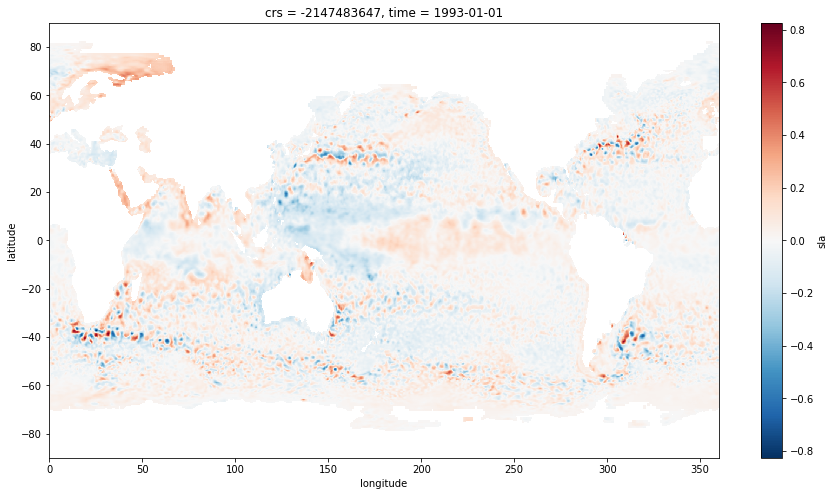

In [6]:
plt.rcParams['figure.figsize'] = (15, 8)
ds.sla.sel(time='1982-08-07', method='nearest').plot()

## Timeseries of Global Mean Sea Level

Here we make a simple yet fundamental calculation: the rate of increase of global mean sea level over the observational period.

In [7]:
# the number of GB involved in the reduction
ds.sla.nbytes/1e9

73.8284544

In [8]:
# the computationally intensive step
sla_timeseries = ds.sla.mean(dim=('latitude', 'longitude')).load()

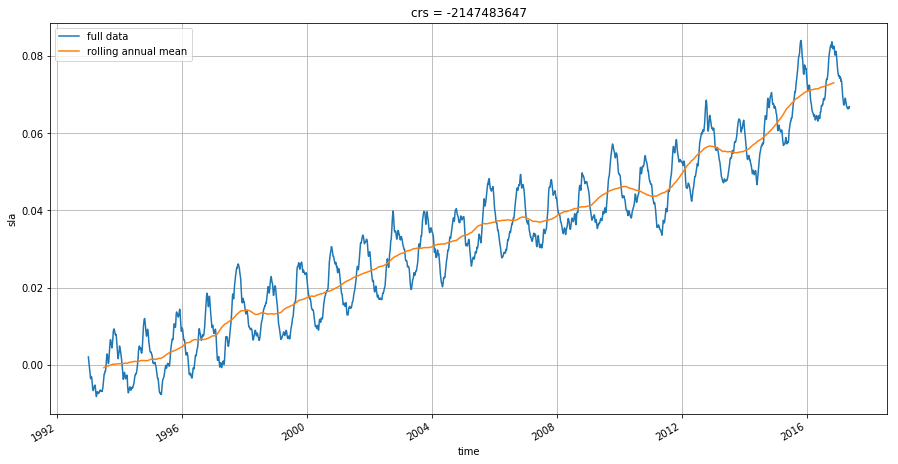

In [9]:
sla_timeseries.plot(label='full data')
sla_timeseries.rolling(time=365, center=True).mean().plot(label='rolling annual mean')
plt.legend()
plt.grid()

In order to understand how the sea level rise is distributed in latitude, we can make a sort of [Hovmöller diagram](https://en.wikipedia.org/wiki/Hovm%C3%B6ller_diagram).

In [10]:
sla_hov = ds.sla.mean(dim='longitude').load()

distributed.core - WARNING - Event loop was unresponsive in Scheduler for 5.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


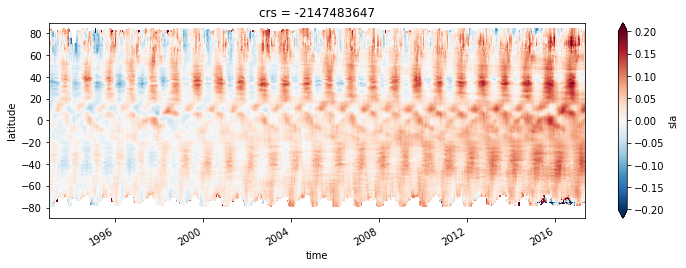

In [11]:
fig, ax = plt.subplots(figsize=(12,4))
sla_hov.transpose().plot(vmax=0.2, ax=ax)

We can see that most sea level rise is actually in the Southern Hemisphere.

## Sea Level Variability

We can examine the natural variability in sea level by looking at its standard deviation in time.

In [12]:
sla_std = ds.sla.std(dim='time').load()

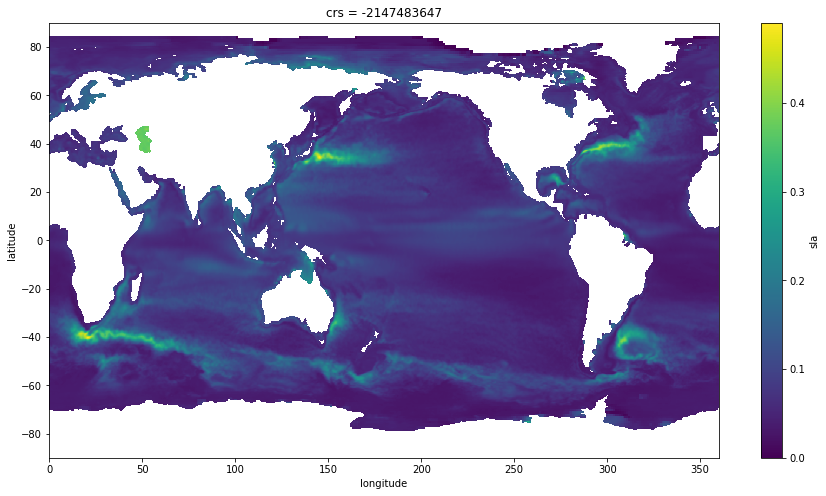

In [13]:
sla_std.plot()